<a href="https://colab.research.google.com/github/SWESH1K/ThinkAI_Paper/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Pest Prediction in Castor Plants

## Connecting the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preprocessing

### Importing Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
seed_value = 42
tf.random.set_seed(seed_value)
image_size = (112, 112)

### Loading the Original Images

In [13]:
original_data_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Dataset/Training Set',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 284 files belonging to 3 classes.


### Loading the Augmented Images

In [4]:
augmented_data_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Dataset/New Aug Images',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3840 files belonging to 3 classes.


### Loading the Test Images

In [22]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Dataset/Testing Set',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 20 files belonging to 3 classes.


### Combining the Original and Augmented Images

In [5]:
train_dataset = tf.data.Dataset.sample_from_datasets(
    [original_data_set, augmented_data_set],
    seed=42
)

In [6]:
total_dataset = orginal_data_set.concatenate(augmented_data_set)

In [7]:
all_images = []
all_labels = []
for images, labels in total_dataset.unbatch():
  all_images.append(images)
  all_labels.append(labels)
# Convert the lists to TensorFlow tensors
all_images = tf.stack(all_images)
all_labels = tf.stack(all_labels)
# Get the indices for each class
class_0_indices = tf.where(tf.equal(all_labels[:, 0], 1))[:, 0]
class_1_indices = tf.where(tf.equal(all_labels[:, 1], 1))[:, 0]
class_2_indices = tf.where(tf.equal(all_labels[:, 2], 1))[:, 0]
# Combine the indices for the full training sets
train_indices = tf.concat([class_0_indices, class_1_indices, class_2_indices], axis=0)
# Shuffle the training indices
train_indices = tf.random.shuffle(train_indices, seed=seed_value)
# Create the training and testing datasets
train_dataset = tf.data.Dataset.from_tensor_slices((tf.gather(all_images, train_indices), tf.gather(all_labels, train_indices))).batch(32)
# Verify the number of images in each dataset
print(f"Number of batches in training dataset: {len(list(train_dataset))}")

Number of batches in training dataset: 129


## Building and Training the Model

In [7]:
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

pre_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

pre_model.trainable = False

model = tf.keras.models.Sequential()
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy', 'precision', 'recall'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,079,619 (130.00 MB)

 Trainable params: 10,491,907 (40.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

In [12]:
# training_history = model.fit(x=train_dataset, validation_data=test_dataset, epochs=20, callbacks=callbacks)

## Accuracy Visualization

In [ ]:
history_dict = training_history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy') # Changed 'b' to 'r' for clarity
plt.title('ResNet50: Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss') # Changed 'b' to 'r' for clarity
plt.title('ResNet50: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluating the Model

### Training Data

In [9]:
#Training set Accuracy
train_loss, train_acc, train_prec, train_recall = model.evaluate(train_dataset)
print('Training accuracy:', train_acc)

104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 1.0000 - loss: 0.0026 - precision_4: 1.0000 - recall_4: 1.0000
Training accuracy: 1.0


In [10]:
print('Training Loss:', round(train_loss*100, 2), "%.")

Training Loss: 0.29 %.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

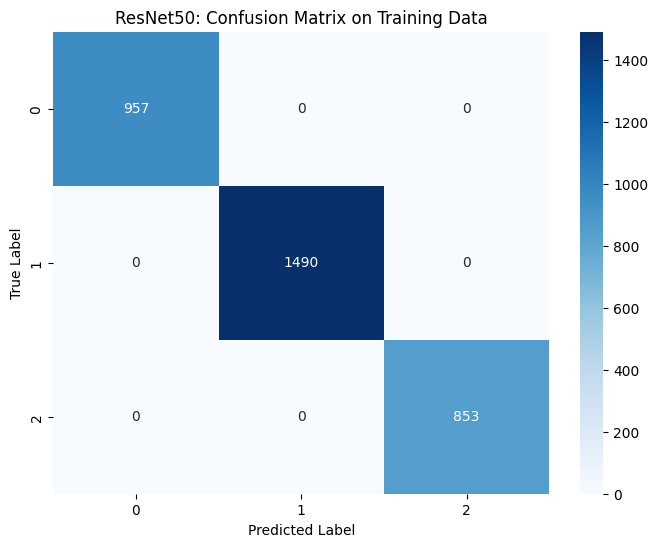

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get true labels and predicted labels for the training dataset
true_labels = []
predicted_labels = []

for images, labels in train_dataset:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
    predictions = model.predict(images)
    predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())

print(len(true_labels))

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet50: Confusion Matrix on Training Data')
plt.show()

### Testing Data

In [16]:
#Test set Accuracy
test_loss, test_acc, test_prec, test_recall = model.evaluate(test_dataset)
print('Validation accuracy:', test_acc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9811 - loss: 0.0424 - precision_4: 0.9811 - recall_4: 0.9811
Validation accuracy: 0.98591548204422


In [17]:
print('Test Loss:', round(test_loss*100, 2), "%")

Test Loss: 2.85 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


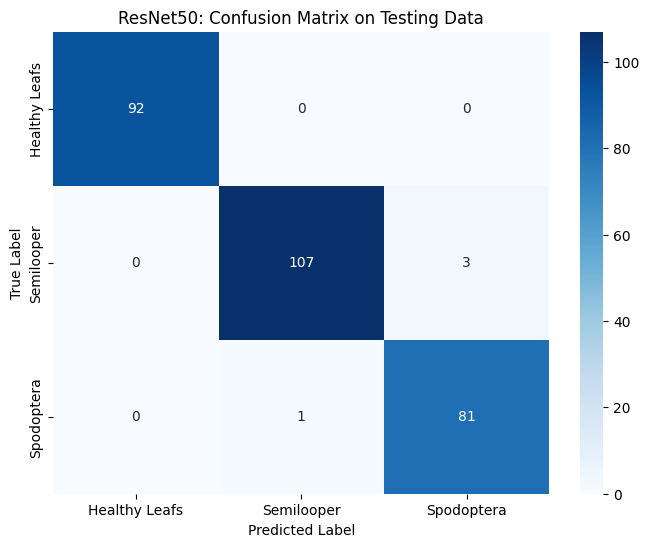

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get true labels and predicted labels for the training dataset
true_labels = []
predicted_labels = []
class_labels = test_dataset.class_names

for images, labels in test_dataset:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
    predictions = model.predict(images)
    predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet50: Confusion Matrix on Testing Data')
plt.show()

## Saving the Model

In [19]:
model.save('/content/drive/MyDrive/ICAR_IIOR/resnet50_imagenet_21_07_2025.keras')

## Stratified K-Fold

### Converting the Test Data into Numpy Arrays

In [6]:
import numpy as np
import tensorflow as tf # Import tensorflow

# Initialize empty lists to store images and labels
X_list = []
y_list = []

# Iterate through the combined training dataset (original + augmented data)
for images, labels in train_dataset:
    X_list.append(images.numpy())
    y_list.append(labels.numpy())

# Concatenate the lists of arrays into single NumPy arrays
X = np.concatenate(X_list, axis=0)
y_one_hot = np.concatenate(y_list, axis=0) # Keep the one-hot encoded labels if needed elsewhere

# Convert one-hot encoded labels to class indices
y = tf.argmax(y_one_hot, axis=1).numpy()

# Now y has shape (num_samples,) with class indices

### Applying the K-Fold

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

# Instantiate Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []
fold_losses = []

test_fold_accuracies = []
test_fold_losses = []

num_classes = 3  # Define your number of classes

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # One-hot encode labels
    y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot)).batch(32)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_one_hot)).batch(32)

    # Build model
    pre_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(112, 112, 3)
    )

    pre_model.trainable = False

    model = tf.keras.models.Sequential()
    model.add(pre_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.6))
    model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        # loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]

    #Using class_weight to reduce overfitting due to class-imbalance
    # from sklearn.utils import class_weight

    # class_weights_array = class_weight.compute_class_weight(
    #     class_weight='balanced',
    #     classes=np.unique(y_train),
    #     y=y_train
    # )

    # Convert to dictionary (this is essential)
    # class_weights = dict(enumerate(class_weights_array))


    # Train model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1, callbacks=callbacks)

    # Evaluate model
    loss, accuracy, precision, recall = model.evaluate(val_dataset, verbose=0)
    print(f"Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)

    # Evaluating on X_test, y_test
    # y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
    # test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot)).batch(32)
    # loss, accuracy, precision, recall = model.evaluate(test_dataset, verbose=0)
    # print(f"Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    # test_fold_losses.append(loss)
    # test_fold_accuracies.append(accuracy)

    # Prediction and analysis
    y_val_preds = model.predict(X_val, verbose=0)
    y_val_pred_labels = np.argmax(y_val_preds, axis=1)
    y_val_true_labels = y_val

    # Confident wrong predictions
    pred_confidences = np.max(y_val_preds, axis=1)
    incorrect_indices = np.where(y_val_pred_labels != y_val_true_labels)[0]
    confident_wrong = [(i, y_val_pred_labels[i], y_val_true_labels[i], pred_confidences[i])
                       for i in incorrect_indices if pred_confidences[i] > 0.9]

    print(f"→ {len(confident_wrong)} confidently wrong predictions (confidence > 0.9)")
    for i, pred, true, conf in confident_wrong[:3]:  # Show only first 3 for brevity
        print(f"Sample {i}: Predicted={pred}, True={true}, Confidence={conf:.2f}")

    # Confusion matrix
    cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_val_true_labels, y_val_pred_labels))

    # Confusion matrix for Test data
    # y_test_preds = model.predict(X_test, verbose=0)
    # y_test_pred_labels = np.argmax(y_test_preds, axis=1)
    # y_test_true_labels = y_test
    # cm_test = confusion_matrix(y_test_true_labels, y_test_pred_labels)
    # print("Confusion Matrix for Test Data:")
    # print(cm_test)
    # print("Classification Report for Test Data:")
    # print(classification_report(y_test_true_labels, y_test_pred_labels))

# Summary
print("\n=== Overall Results ===")
print(f"Average Validation Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Std Dev of Validation Accuracy: {np.std(fold_accuracies):.4f}")
print(f"Average Validation Loss: {np.mean(fold_losses):.4f}")
print(f"Std Dev of Validation Loss: {np.std(fold_losses):.4f}")
# print(f"Average Test Accuracy: {np.mean(test_fold_accuracies):.4f}")
# print(f"Std Dev of Test Accuracy: {np.std(test_fold_accuracies):.4f}")
# print(f"Average Test Loss: {np.mean(test_fold_losses):.4f}")
# print(f"Std Dev of Test Loss: {np.std(test_fold_losses):.4f}")


--- Fold 1/5 ---
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.6578 - loss: 0.8332 - precision: 0.6836 - recall: 0.6120 - val_accuracy: 0.8836 - val_loss: 0.3187 - val_precision: 0.8899 - val_recall: 0.8715 - learning_rate: 1.0000e-04
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8692 - loss: 0.3341 - precision: 0.8739 - recall: 0.8589 - val_accuracy: 0.9103 - val_loss: 0.2500 - val_precision: 0.9127 - val_recall: 0.8994 - learning_rate: 1.0000e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9006 - loss: 0.2531 - precision: 0.9072 - recall: 0.8940 - val_accuracy: 0.9188 - val_loss: 0.2213 - val_precision: 0.9193 - val_recall: 0.9115 - learning_rate: 1.0000e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9302 - loss: 0.1915 - precision: 0.9327 - recall: 0.9264 - val_accuracy: 0.9079 - val_loss: 0.2535 - val_precision: 0.9095 - val_recall: 0.9018 - learning_rate: 1.0000e-04
Epoch 5/20
104/104 ━━━━━